In [1]:
import sys
sys.path.insert(0, "/home/ubuntu/data/code/Modules/")
import skimage
import numpy as np
import pickle
import gc
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.metrics import confusion_matrix
import cv2
import matplotlib.pyplot as plt
from keras import backend
from keras.models import Sequential
from keras.losses import binary_crossentropy
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, BatchNormalization, Flatten, Dropout
from keras.optimizers import SGD,Adadelta
import DataGenerator
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import random
import glob
import CNN_Module as cnn_module
import models
import glue_code

Using TensorFlow backend.


In [2]:
import imp
imp.reload(cnn_module)
imp.reload(models)

<module 'models' from '/home/ubuntu/data/code/Modules/models.py'>

In [3]:
import warnings
warnings.filterwarnings('ignore')
model = models.get_luke_model_140(input_shape=(140,100,1))
#model = models.get_luke_model_noBN(140,100)
augment_train, augment_valid = cnn_module.get_augmentations_train_test()
params_train, params_test = cnn_module.get_params_train_test(140,100,augment_valid,augment_valid)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
cipro_con_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/resistant/'))
trim_con_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/trimdata/resistant/'))
ceph_con_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/cephdata/resistant/'))

cipro_sus_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/susceptible/'))
trim_sus_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/trimdata/susceptible/'))
ceph_sus_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/cephdata/susceptible/'))

print('res_cipro =',len(cipro_con_cells))
print('res_trim =',len(trim_con_cells))
print('res_ceph =',len(ceph_con_cells))

print('sus_cipro =',len(cipro_sus_cells))
print('sus_trim =',len(trim_sus_cells))
print('sus_ceph =',len(ceph_sus_cells))

res_cipro = 318
res_trim = 253
res_ceph = 221
sus_cipro = 362
sus_trim = 257
sus_ceph= 228


In [4]:
cipro_con_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/resistant/'))
trim_con_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/trimdata/resistant/'))

cipro_sus_cells     = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/susceptible/'))
trim_sus_cells     = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/trimdata/susceptible/'))

#start by getting the test set from the data
trim_con_labels = cnn_module.create_label_dict(trim_con_cells,0)
trim_sus_labels  = cnn_module.create_label_dict(trim_sus_cells,1)

trim_train_ctrl, trim_test_ctrl = cnn_module.split_train_test(trim_con_labels,0.85)
trim_train_sus, trim_test_sus = cnn_module.split_train_test(trim_sus_labels,0.85)

print(len(trim_train_ctrl))
print(len(trim_train_sus))
#print(cipro_con_cells)
#prepare the rest of the data
random.shuffle(cipro_con_cells)
random.shuffle(cipro_sus_cells)
cipro_con1 = cipro_con_cells[:(len(trim_train_ctrl))]
cipro_sus1 = cipro_sus_cells[:(len(trim_train_sus))]
print('control cells from each data set for train =',len(cipro_con1))
print('susceptible cells from each data set for train =',len(cipro_sus1))

control_cells_label = cnn_module.create_label_dict(cipro_con1,0)
sus_cells_label  = cnn_module.create_label_dict(cipro_sus1,1)

rest_ctrl, throw1 = cnn_module.split_train_test(control_cells_label,1)
rest_sus, throw2 = cnn_module.split_train_test(sus_cells_label,1)

train_labels = rest_sus+rest_ctrl+trim_train_ctrl+trim_train_sus
test_labels = trim_test_ctrl+trim_test_sus
random.shuffle(train_labels)
random.shuffle(test_labels)

print(len(train_labels))
print(len(test_labels))
print(test_labels)

215
218
control cells from each data set for train = 215
susceptible cells from each data set for train = 218
866
77
[('/home/ubuntu/data/trimdata/susceptible/sample15/cell134', 1), ('/home/ubuntu/data/trimdata/resistant/sample26/cell313', 0), ('/home/ubuntu/data/trimdata/resistant/sample12/cell687', 0), ('/home/ubuntu/data/trimdata/susceptible/sample02/cell069', 1), ('/home/ubuntu/data/trimdata/susceptible/sample05/cell260', 1), ('/home/ubuntu/data/trimdata/resistant/sample26/cell342', 0), ('/home/ubuntu/data/trimdata/susceptible/sample14/cell151', 1), ('/home/ubuntu/data/trimdata/resistant/sample26/cell316', 0), ('/home/ubuntu/data/trimdata/susceptible/sample14/cell146', 1), ('/home/ubuntu/data/trimdata/susceptible/sample05/cell253', 1), ('/home/ubuntu/data/trimdata/resistant/sample18/cell417', 0), ('/home/ubuntu/data/trimdata/susceptible/sample15/cell123', 1), ('/home/ubuntu/data/trimdata/resistant/sample23/cell146', 0), ('/home/ubuntu/data/trimdata/susceptible/sample13/cell140', 1)

In [ ]:
result_acc = []
result_val_acc = []
result_val_loss = []
result_loss = []
epochs=30
stepsperepoch=100
sample_gap = 10
model = models.get_luke_model_140(input_shape=(140,100,1))
for repeat in np.arange(0,5):
    print('repeat =', repeat)
    #prep cells for feeding into CNN
    cipro_con_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/resistant/'))
    trim_con_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/trimdata/resistant/'))

    cipro_sus_cells     = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/susceptible/'))
    trim_sus_cells     = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/trimdata/susceptible/'))

    #start by getting the test set from the data
    trim_con_labels = cnn_module.create_label_dict(trim_con_cells,0)
    trim_sus_labels  = cnn_module.create_label_dict(trim_sus_cells,1)

    trim_train_ctrl, trim_test_ctrl = cnn_module.split_train_test(trim_con_labels,0.85)
    trim_train_sus, trim_test_sus = cnn_module.split_train_test(trim_sus_labels,0.85)

    print(len(trim_train_ctrl))
    print(len(trim_train_sus))
    #print(cipro_con_cells)
    #prepare the rest of the data
    random.shuffle(cipro_con_cells)
    random.shuffle(cipro_sus_cells)
    cipro_con1 = cipro_con_cells[:(len(trim_train_ctrl))]
    cipro_sus1 = cipro_sus_cells[:(len(trim_train_sus))]
    print('control cells from each data set for train =',len(cipro_con1))
    print('susceptible cells from each data set for train =',len(cipro_sus1))

    control_cells_label = cnn_module.create_label_dict(cipro_con1,0)
    sus_cells_label  = cnn_module.create_label_dict(cipro_sus1,1)

    rest_ctrl, throw1 = cnn_module.split_train_test(control_cells_label,1)
    rest_sus, throw2 = cnn_module.split_train_test(sus_cells_label,1)

    train_labels = rest_sus+rest_ctrl+trim_train_ctrl+trim_train_sus
    test_labels = trim_test_ctrl+trim_test_sus
    random.shuffle(train_labels)
    random.shuffle(test_labels)

    print(len(train_labels))
    print(len(test_labels))


    video_path = '/cropped_video100_140'
    im_paths_train, im_labels_train, im_paths_test, im_labels_test = cnn_module.get_labels_images(train_labels,test_labels,video_path,sample_gap)
    random.shuffle(im_paths_train)
    random.shuffle(im_paths_test)
    
    epochs=30
    stepsperepoch=100
    sample_gap = 10
    validate_steps = len(im_paths_test)//32
    model = models.get_luke_model_140(input_shape=(140,100,1))
    
    #augment_train, augment_valid = cnn_module.get_augmentations_train_test()
    
    params_train, params_test = cnn_module.get_params_train_test(140,100,augment_valid,augment_valid) #no flipping

    training_generator = DataGenerator.DataGenerator(im_paths_train, im_labels_train, **params_train)
    prediction_generator = DataGenerator.DataGenerator(im_paths_test, im_labels_test, **params_test)
    

    fully_train_model = cnn_module.fit_model(model,training_generator,prediction_generator,epochs,stepsperepoch,validate_steps,params_train,params_test)
    
    run_val_acc = model.history.history['val_acc']
    run_val_loss = model.history.history['val_loss']
    run_acc = model.history.history['acc']
    run_loss = model.history.history['loss']
    
    result_val_acc.append(run_val_acc)
    result_val_loss.append(run_val_loss)
    result_acc.append(run_acc)
    result_loss.append(run_loss)

repeat = 0
215
218
control cells from each data set for train = 215
susceptible cells from each data set for train = 218
866
77


Epoch 1/30
100/100 [==============================] - 14s 143ms/step - loss: 3.9651 - acc: 0.5787 - val_loss: 0.6740 - val_acc: 0.4817
Epoch 2/30
100/100 [==============================] - 7s 67ms/step - loss: 0.8055 - acc: 0.5687 - val_loss: 0.6649 - val_acc: 0.5599
Epoch 3/30
100/100 [==============================] - 7s 65ms/step - loss: 0.7628 - acc: 0.5919 - val_loss: 0.6750 - val_acc: 0.6265
Epoch 4/30
100/100 [==============================] - 7s 69ms/step - loss: 0.6946 - acc: 0.6003 - val_loss: 0.6425 - val_acc: 0.6228
Epoch 5/30
100/100 [==============================] - 6s 64ms/step - loss: 0.6790 - acc: 0.6247 - val_loss: 0.6624 - val_acc: 0.6016
Epoch 6/30
100/100 [==============================] - 6s 64ms/step - loss: 0.6657 - acc: 0.6300 - val_loss: 0.6575 - val_acc: 0.6023
Epoch 7/30
100/100 [==============================] - 6s 55ms/step - l

In [56]:
result = (result_val_acc, result_val_loss, result_acc, result_loss)
print(result)

([[0.6310307011008263, 0.6277412293772948, 0.7757675404611387, 0.734100875885863, 0.7774122820088738, 0.726425439119339, 0.6831140353491432, 0.7066885993668908, 0.7894736834262547, 0.6847587733676559, 0.5087719316545286, 0.6606359693564867, 0.662280703845777, 0.7088815813001833, 0.66337719324388, 0.7637061421808443, 0.7033991225455937, 0.7302631578947368, 0.7017543876641675, 0.7505482482282739, 0.7225877179911262, 0.773026317358017, 0.666118422229039, 0.7571271920674726, 0.6699561413965727, 0.732456138651622, 0.7467105271000611, 0.6573464921430537, 0.7275219316545286, 0.7116228075403916], [0.7214912297694307, 0.5904605259236536, 0.6940789442313345, 0.7110745624492043, 0.6244517549088127, 0.6885964901823747, 0.5915570176745716, 0.6052631571104652, 0.6480263189265603, 0.5910087733676559, 0.6452850879807221, 0.6584429835018358, 0.6869517505953187, 0.6661184218369032, 0.7225877183832621, 0.7039473703817317, 0.7072368432816706, 0.6458333358168602, 0.6918859626901778, 0.6737938601719705, 0.7

In [57]:
#pickle.dump(result, open('/home/ubuntu/data/code/2dCNN/trimcipro_train_trim_test3.p','wb'))

In [58]:
import pickle
result_all = pickle.load(open('/home/ubuntu/data/code/2dCNN/trimcipro_train_trim_test3.p','rb'))
val_acc_all = result_all[0]
val_loss_all = result_all[1]
acc_all = result_all[2]
loss_all = result_all[3]

In [59]:
import numpy as np

val_acc_avg = np.mean(val_acc_all, axis = 0)
print(val_acc_avg)

acc_avg = np.mean(acc_all, axis = 0)
print(acc_avg)

[0.69542939 0.65769063 0.73183194 0.7145895  0.6788681  0.69425695
 0.63953682 0.66982086 0.70301227 0.64964257 0.54882709 0.66624421
 0.65934011 0.67279942 0.68908066 0.6966493  0.69513984 0.69282582
 0.69849339 0.70169268 0.69532496 0.72611928 0.6909034  0.72441283
 0.64899227 0.70814346 0.67320764 0.68164967 0.69494522 0.63819587]
[0.56833333 0.59447917 0.6140625  0.64354167 0.66364583 0.69947917
 0.73510417 0.77364583 0.818125   0.86       0.89395833 0.91635417
 0.93916667 0.95458333 0.968125   0.97229167 0.98       0.98385417
 0.98322917 0.98697917 0.98802083 0.98895833 0.989375   0.9875
 0.9903125  0.98979167 0.988125   0.99125    0.98916667 0.990625  ]


(0.5, 1)

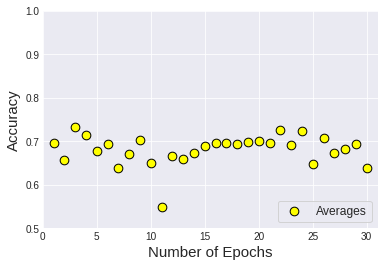

In [60]:
x_vals=np.arange(1,31)

#bests = [np.max(np.array(i)[:,1]) for i in data]
#stds = [np.std(np.array(i)[:,1]) for i in data]

plt.style.use('seaborn-darkgrid')

#plt.scatter(np.array(data)[:,0],np.array(data)[:,1],marker='x', alpha= 0.5, label='Individual runs',color='black')
plt.scatter(x_vals,val_acc_avg, marker='o', s= 75, label='Averages',color='yellow', edgecolors='black',linewidth=1)
#plt.errorbar(x_vals,data_av,std,elinewidth=2,color='maroon',label='std')
plt.legend(loc='lower right',frameon=True, fontsize=12)
#plt.title('Sample gap vs accuracy')
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.xticks(np.arange(0, 36, 5))
plt.xlim(0,31)
plt.ylim(0.5,1)

#plt.savefig('/home/ubuntu/data/figs/2d_cr_val_acc.png', dpi=500)

(0.5, 1)

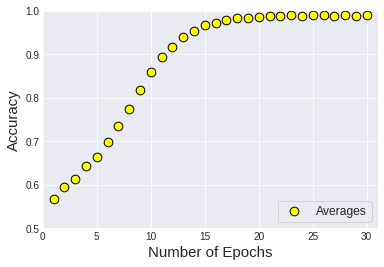

In [61]:
x_vals=np.arange(1,31)

#bests = [np.max(np.array(i)[:,1]) for i in data]
#stds = [np.std(np.array(i)[:,1]) for i in data]

plt.style.use('seaborn-darkgrid')

#plt.scatter(np.array(data)[:,0],np.array(data)[:,1],marker='x', alpha= 0.5, label='Individual runs',color='black')
plt.scatter(x_vals,acc_avg, marker='o', s= 75, label='Averages',color='yellow', edgecolors='black',linewidth=1)
#plt.errorbar(x_vals,data_av,std,elinewidth=2,color='maroon',label='std')
plt.legend(loc='lower right',frameon=True, fontsize=12)
#plt.title('Sample gap vs accuracy')
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.xticks(np.arange(0, 36, 5))
plt.xlim(0,31)
plt.ylim(0.5,1)

#plt.savefig('/home/ubuntu/data/figs/2d_cr_acc.png', dpi=500)